In [1]:
%%capture
##############################################################################
# IGNORE if you are running on a local machine and have all the dependencies #
##############################################################################

# installing dependencies --- to be able to run on google colab
# it would take 2-3 minutes

!yes | pip3 uninstall pandas
!yes | pip3 uninstall geopandas

!apt-get install libspatialindex-c4v5;
!pip3 install Rtree;
!pip3 install osmnx;
!pip3 install tqdm;
!pip3 install ipyleaflet;
!pip3 install pandas==1.0.4
!pip3 install geopandas==0.7.0

# You need to upload utilities.zip in /content directory which is the default
!unzip utilities.zip

In [2]:
import osmnx as ox
import networkx as nx
from utilities import *

## Handling osmnx graphs

graphs returned from `osmnx` are `networkx` multidigraphs which is expected because we need to represent self-loops and directed and parallel roads in maps.

In [11]:
G = ox.graph_from_address("toronto")
type(G)

networkx.classes.multidigraph.MultiDiGraph

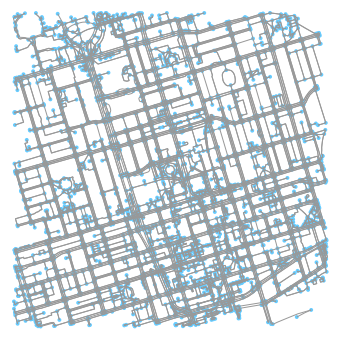

In [6]:
fig, ax = ox.plot_graph(G)

let's list all the nodes of the graph

In [7]:
[*G.nodes()]

[3597533185,
 3597533187,
 6294585384,
 261718070,
 3057123387,
 3057123388,
 700645449,
 3697967180,
 3715285073,
 3715285075,
 3715285076,
 261718099,
 3715285079,
 3715285081,
 3715285082,
 3443966044,
 6294585440,
 29687905,
 29687908,
 29687910,
 29687912,
 29687913,
 29687914,
 1409286252,
 1409286257,
 1409286260,
 6294585461,
 1409286262,
 1409286263,
 6294585463,
 519913606,
 402129030,
 3696230536,
 402129032,
 3696230538,
 402129034,
 402129036,
 402129038,
 3696230543,
 3696230547,
 3696230553,
 3696230555,
 3696230557,
 3696230558,
 3696230559,
 281673890,
 1409286308,
 402129062,
 1409286312,
 3705421992,
 3705421994,
 3705421993,
 402129068,
 3705421997,
 3705421998,
 29687983,
 3705421999,
 29687984,
 29687985,
 29687986,
 3705422004,
 3705422005,
 605208758,
 29687989,
 29687992,
 605208763,
 261718221,
 2478473423,
 2478473426,
 391004375,
 391004376,
 3722117337,
 3722117338,
 391004377,
 2411561185,
 769507565,
 769507566,
 769507568,
 769507570,
 769507571,
 261718

accessing a single node

In [8]:
G[3597533187]

AdjacencyView({6710562607: {0: {'osmid': 96152051, 'name': 'Eaton Centre level 2', 'highway': 'footway', 'oneway': False, 'length': 3.883}}, 3597533185: {0: {'osmid': 353964120, 'name': 'Escalator from Eaton Centre level 1 to 2', 'highway': 'steps', 'oneway': False, 'length': 4.309}}, 6710562608: {0: {'osmid': 96152051, 'name': 'Eaton Centre level 2', 'highway': 'footway', 'oneway': False, 'length': 117.22, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f6ae3971ef0>}}})

This is the adjacency list of this node as dictionary with keys as the osmid of the neighbour nodes and as we said before that the osmid inside the values in the dictionary are the osmid of the roads.  

So one of the neighbours ofthe node `3597544187` is `6710562607` and the edge connecting both of them is `96152051` which is "Eaton Centre level 2" which apparently is highway.  

The ids of the nodes are unique and the ids of the roads are uniques but as we have discussed before that it is acceptable to have the same id for a node and road without any problem.  

---
---

As you would imagine doing anything useful with the graph requires accessing the neighbour of some node and the edge connecting them together.  

We can do that with our graph like that.

In [9]:
G[3597533187][6710562607] # returning the edge between them

AtlasView({0: {'osmid': 96152051, 'name': 'Eaton Centre level 2', 'highway': 'footway', 'oneway': False, 'length': 3.883}})

In [10]:
G[3597533187][6710562607][0]['length'] # accessing the length of the edge between them

3.883

Obviously accessing the edge data and traversing the node neighbours with the above statements would obfuscate any algorithm and make it really hard to follow and to be read.

That is why we provided a wrapper around the returned from `osmnx` that offers the same results but in a more idiomatic way.

In [12]:
# from utilitis/utils/common.py
node = Node(G, 3597533187)

to create the node you need to pass the whole graph and the id of that node

In [16]:
# accessing a give node's id -- useful when
# you have a container of these objects and
# want to retrieve one
node.osmid 

3597533187

In [17]:
neighbours = node.expand()

In [18]:
neighbours

as you can see node.expand() returned the neighbours of that nodes and to check them you need to access their osmid

In [19]:
for node in neighbours:
    print(node.osmid)

6710562607
3597533185
6710562608


to know the distance between two nodes you access `distance` attribute on the child node to know for example the distance between the node with id `6710562607` and `3597533187`

In [20]:
# 6710562607 is the first element in neighbours list
neighbours[0].distance

3.883

and obviously you need to know from where a given node was expanded

In [22]:
(neighbours[0].parent).osmid

3597533187

let's expand `neighbours[0]` one more time

In [23]:
neighbours_2 = neighbours[0].expand()

In [24]:
for node in neighbours_2:
    print(node.osmid)

3597533187
6710500027
6710562606


Pay attention to the expansion sequence -- we have expanded `3597533187` and then `6710562607`(first child) and then `6710500027` (second child)

`3597533187` appeared twice because there is a way from `3597533187` to `6710562607` and another way in the opposite direction

to know the node that caused other node to be expanded, just access the `parent` attribute

In [25]:
(neighbours_2[1].parent).osmid

6710562607

and to get the path from the first node ever expanded to the current node, invoke the function `path()`

In [26]:
(neighbours_2[1]).path() 

[3597533187, 6710562607, 6710500027]

# Random Paths

In some situations we need to generate a random path from two nodes, we can do that using `randomized search`

In [27]:
source(randomized_search)

In [28]:
route = randomized_search(G, 3715285073, 416727716)

In [29]:
route

[3715285073,
 3715403396,
 3715285081,
 3715285082,
 3715270164,
 2481672564,
 3559283221,
 391005489,
 3559450506,
 3559450511,
 394497109,
 391012576,
 59566704,
 394490778,
 394497127,
 394497128,
 394497129,
 394497130,
 536331889,
 29689521,
 394490741,
 2401060263,
 416731314,
 34598911,
 394497132,
 416731309,
 416731310,
 29605068,
 416727716]

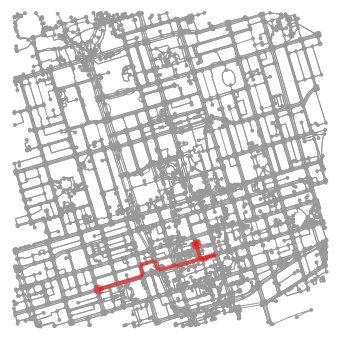

(<Figure size 597.681x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6add1ac358>)

In [30]:
ox.plot_graph_route(G, route)